In [177]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas_datareader import data

tf.random.set_seed(8)
start = "2017"
end = "2022"
source = "yahoo"
tickers = ["IBM"]

df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["Date"]
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-03,160.487579,158.709366,159.655838,159.837479,3069278.0,124.062180
1,2017-01-04,162.399612,160.000000,160.391968,161.816437,3536944.0,125.598160
2,2017-01-05,161.940720,159.904404,161.806885,161.281067,2805686.0,125.182686
3,2017-01-06,162.447418,160.152969,161.271515,162.074570,3080993.0,125.798553
4,2017-01-09,162.332703,160.248566,162.017212,160.277252,3336635.0,124.403511


In [178]:
cols = list(df)[1:6]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,High,Low,Open,Close,Volume
0,160.487579,158.709366,159.655838,159.837479,3069278.0
1,162.399612,160.000000,160.391968,161.816437,3536944.0
2,161.940720,159.904404,161.806885,161.281067,2805686.0
3,162.447418,160.152969,161.271515,162.074570,3080993.0
4,162.332703,160.248566,162.017212,160.277252,3336635.0
...,...,...,...,...,...
1254,131.649994,129.949997,130.630005,131.619995,4293900.0
1255,133.220001,131.589996,131.600006,132.630005,3445200.0
1256,134.210007,132.300003,132.399994,133.350006,4239900.0
1257,134.369995,133.330002,133.750000,133.910004,3158100.0


In [179]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[ 0.64914775,  0.66998669,  0.65675083,  0.66139019, -0.90554507],
       [ 0.69617859,  0.69986724,  0.67437078,  0.70887792, -0.88129265],
       [ 0.68489107,  0.69765401,  0.70823813,  0.69603101, -0.91921454],
       ...,
       [ 0.00279054,  0.0585614 ,  0.00435687,  0.02578811, -0.84483847],
       [ 0.00672582,  0.08240777,  0.03667052,  0.03922599, -0.9009389 ],
       [ 0.0219764 ,  0.08889025,  0.0426545 ,  0.03322691, -0.89035979]])

In [180]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(944, 5)
(315, 5)


In [181]:
days_future = 1
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(930, 14, 5)
(930, 1)
(301, 14, 5)
(301, 1)


In [213]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 14, 64)            17920     
_________________________________________________________________
lstm_61 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [214]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
15/15 [==============================] - 4s 64ms/step - loss: 0.1303 - val_loss: 0.1308
Epoch 2/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1212 - val_loss: 0.1317
Epoch 3/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1283 - val_loss: 0.1313
Epoch 4/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1301 - val_loss: 0.1319
Epoch 5/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1206 - val_loss: 0.1309
Epoch 6/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1175 - val_loss: 0.1318
Epoch 7/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1242 - val_loss: 0.1311
Epoch 8/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1300 - val_loss: 0.1313
Epoch 9/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1169 - val_loss: 0.1312
Epoch 10/10
15/15 [==============================] - 0s 15ms/step - loss: 0.1296 - val_loss: 0.1318


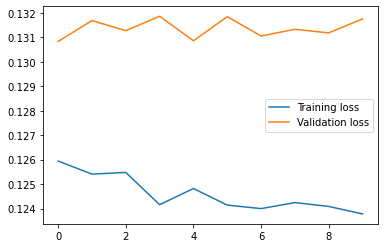

In [215]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [229]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

In [230]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [231]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_forecast})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [232]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-7-1']

<ipython-input-232-2eb051472853>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


C:\Users\david\anaconda3v2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\david\anaconda3v2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Open'>

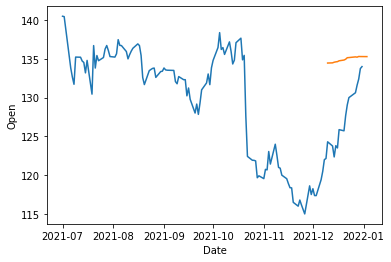

In [233]:
import seaborn as sns

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

In [196]:
df_forecast

,Date,Open
0,2021-12-10,134.459732
1,2021-12-13,134.497101
2,2021-12-14,134.525711
3,2021-12-15,134.576782
4,2021-12-16,134.684784
5,2021-12-17,134.809982
6,2021-12-20,134.939606
7,2021-12-21,135.024002
8,2021-12-22,135.187622
9,2021-12-23,135.145935


In [197]:
result = df.merge(df_forecast, how="outer", on=["Date", "Open"])
result

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-03,160.487579,158.709366,159.655838,159.837479,3069278.0,124.062180
1,2017-01-04,162.399612,160.000000,160.391968,161.816437,3536944.0,125.598160
2,2017-01-05,161.940720,159.904404,161.806885,161.281067,2805686.0,125.182686
3,2017-01-06,162.447418,160.152969,161.271515,162.074570,3080993.0,125.798553
4,2017-01-09,162.332703,160.248566,162.017212,160.277252,3336635.0,124.403511
...,...,...,...,...,...,...,...
1269,2021-12-27,NaN,NaN,135.183685,NaN,NaN,NaN
1270,2021-12-28,NaN,NaN,135.179535,NaN,NaN,NaN
1271,2021-12-29,NaN,NaN,135.287292,NaN,NaN,NaN
1272,2021-12-30,NaN,NaN,135.296646,NaN,NaN,NaN


In [198]:
result.to_csv("IBM_US_data.csv")